# Performance Evaluation

The first part of this notebook summarizes the conventional performance measures for an investment fund. The second part does a "style analysis" to find out how the fund has changed its portfolio weights over time.

## Load Packages and Extra Functions

In [1]:
using Dates, DelimitedFiles, Statistics

include("jlFiles/printmat.jl")
include("jlFiles/printTable.jl")

printTable2

In [2]:
using Plots

#pyplot(size=(600,400))           #pyplot or gr
gr(size=(480,320))
default(fmt = :svg)

# Loading Data

In [3]:
(x,header) = readdlm("Data/Fin1PerfEvalEmp.csv",',',header=true)

(IndNames,FundNames) = (header[2:9],header[10:11])     #names of variables

dN             = Date.(x[:,1],"yyyy-mm-dd")       #convert to Date
(Rb,RFunds,Rf) = (convert.(Float64,x[:,2:9]),convert.(Float64,x[:,10:11]),
                  convert.(Float64,x[:,12]));     #convert to Float64

# Performance Evaluation

The next few cells report a number of different performance measures for the funds.

## Sharpe Ratio and M2

In [4]:
Re  = RFunds .- Rf           #excess returns of the funds
Rme = Rb[:,1] - Rf           #excess returns of the market (S&P 500)

μᵉp = mean(Re,dims=1)        #average excess returns of funds, 1xn
σp  = std(Re,dims=1)         #std, 1xn

μᵉm = mean(Rme)              #average excess returns of market
σm  = std(Rme)

SRp = (μᵉp./σp)*sqrt(52)       #Sharpe ratio
SRm = (μᵉm/σm)*sqrt(52)

M2p = (SRp.-SRm)*σm*sqrt(52)*100
M2m = 0                      #(SRm.-SRm)*σm=0

xut = hcat([μᵉm;μᵉp']*52*100,[SRm;SRp'],[M2m;M2p'])
printTable(xut,["ERe","SR","MM"],["Market";FundNames])

                                        ERe        SR        MM
Market                                4.696     0.268     0.000
Putnam Asset Allocation: Growth A     4.143     0.283     0.265
Vanguard Wellington                   5.234     0.489     3.865



## Appraisal Ratio

In [5]:
T = size(Re,1)
x = [ones(T) Rme]

b  = x\Re            #2xn, OLS Re = α + β*Rme + ϵ, n = number of funds
ϵ  = Re - x*b        #Txn, residuals
σϵ = std(ϵ,dims=1)   #1xn

ARp = (b[1:1,:]*52*100)./(σϵ*sqrt(52)*100)   #b[1:1,:] is 1xn
ARm = 0

xut = [ARm;ARp']
printTable(xut,["AR"],["Market";FundNames])

                                         AR
Market                                0.000
Putnam Asset Allocation: Growth A     0.092
Vanguard Wellington                   0.671



## Treynor's Ratio and T2

In [6]:
TRp = 52*100*μᵉp./b[2:2,:]
TRm = 52*100*μᵉm/1           #market has β=1

T2p = TRp .- μᵉm*52*100      
T2m = 0                      #TRm - μᵉm*52*100

xut = hcat([TRm;TRp'],[T2m;T2p'])
printTable(xut,["TR","T2"],["Market";FundNames])

                                         TR        T2
Market                                4.696     0.000
Putnam Asset Allocation: Growth A     5.193     0.497
Vanguard Wellington                   9.158     4.462



# Style Analysis

using the JuMP and Ipopt packages.


Notice:  
(a)  The regression is $Y = b_1 X_1 + ...+ b_K X_K + u$,
               where $0 <= b_j$ and $\sum_{i=1}^{K}b_i = 1$. 
               
(b) Write the sum of squared residuals of the regression as   

$(Y-Xb)'(Y-Xb) = Y'Y - 2Y'Xb + b'X'Xb$. 

Only the two last terms matter for the choice of $b$. 
                             
(c) To minimize $- 2Y'Xb + b'X'Xb$, we use the JuMP package. To speed up the iteration we calculate $Y'X$ and $X'X$ only once.

Notice, we could equally well minimize $(Y-Xb)'(Y-Xb)$, but that is slower since we have re-evaluate the whole expression (including $Y'Y$ and $X'X$) in each iteration.

In [7]:
using JuMP, Ipopt

function StyleAnalysisPs(Y,X)

    (T,K) = (size(X,1),size(X,2))
    XX = X'X                           #calculate XX and YX once
    YX = Y'X

    b_ls = X\Y                          #LS estimate of weights, no restrictions

    model = Model(optimizer_with_attributes(Ipopt.Optimizer,"print_level" => 1))
    @variable(model,b[i=1:K] >= 0.0)         #no short sales
    @objective(model,Min,-2*YX*b + b'*XX*b)  #min (Y-X*b)'*(Y-X*b) also works
    @constraint(model,sum(b) == 1.0)         #sums to 1
    optimize!(model)
    if has_values(model)
        b_sa = value.(b)
    else
        b_sa = NaN
    end

    return b_sa,b_ls

end

StyleAnalysisPs (generic function with 1 method)

The next cell makes a "style analysis regression" based on the entire sample. The dependent variable is the first mutual fund in RFunds (see data loading) and all indices (again, see data loading) are used as regressors.

In [8]:
(b,b_ls) = StyleAnalysisPs(RFunds[:,1],Rb)

printblue("OLS and style analysis coeffs")
colNames = ["OLS" "Restricted LS"]
xut      = [b_ls b;sum([b_ls b],dims=1)]
printTable(xut,colNames,[IndNames;"Sum"],width=15)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

OLS and style analysis coeffs
                                      OLS  Restricted LS
S&P 500                             0.429          0.429
S&P MidCap 400                      0.086          0.087
S&P Small Cap 600                   0.067          0.069
World Developed - Ex. U.S.          0.199          0.203
Emerging Markets                    0.054          0.058
US Corporate Bonds                  0.176          0.071
U.S. Treasury Bills                 0.085          0.083
US Treasury                        -0.151          0.000
Sum                                 0.944          1.000



# Redo the Style Analysis on a Moving Data Window 

of size `WinSize` (see below). Then plot to see how the coefficients change over time. 

In [9]:
(T,K)   = size(Rb)
WinSize = 104

b = fill(NaN,(T,K))
for t = (WinSize+1):T
    #local vv                 #only needed in REPL/script
    vv     = (t-WinSize):t
    b[t,:] = StyleAnalysisPs(RFunds[vv,1],Rb[vv,:])[1]
end

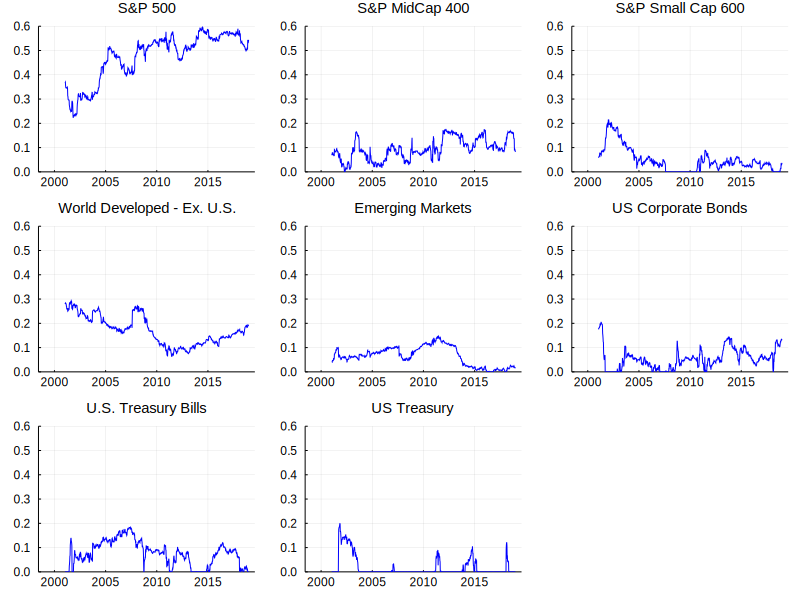

In [10]:
xTicksLoc = Dates.value.([Date(2000);Date(2005);Date(2010);Date(2015)])
xTicksLab = ["2000";"2005";"2010";"2015"]

p1 = plot( dN,b,
           layout = (3,3),
           legend = false,
           size = (800,600),
           linecolor = :blue,
           xticks = (xTicksLoc,xTicksLab),
           ylims = (0,0.6),
           title = [permutedims(IndNames) ""],
           titlefont =font(10) )

#modify subplot [3,3] to be blank
plot!(p1[3,3],legend=false,grid=false,foreground_color_subplot=:white)